In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

if os.getcwd() == '/content':
  % cd drive/MyDrive/exjobb_project

print(os.getcwd())

/content/drive/MyDrive/exjobb_project
/content/drive/MyDrive/exjobb_project


In [3]:
# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import multilabel_confusion_matrix

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import regex as re
import json
import pandas as pd
import numpy as np
import torch
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import BCELoss
from collections import Counter

In [4]:
path_to_data = './data'

# create dataframe from sessions.json
df = pd.read_json(f'{path_to_data}/sessions/sessions_02.json')
df.head()

# create dictionaries for switching between symptom and id
id2sym = {}
sym2id = {}
for filename in os.listdir(f'{path_to_data}/symptoms'):
  with open(f'{path_to_data}/symptoms/{filename}') as json_file:
      data = json.load(json_file)
      for sym in data:
          #print(sym['id'])
          id2sym[sym['id']] = sym['name']
          sym2id[sym['name']] = sym['id']
        
print(len(sym2id))
        
# remove labels that have less than m occurrences
m = 0

labels_list = df['confirmed'].tolist()
labels_list = sum(labels_list, [])
c = Counter(labels_list)
for i in range(len(df)):
    to_remove = []
    
    # find labels that should be removed 
    for j in range(len(df['confirmed'][i])):
        if c[df['confirmed'][i][j]] < m:
            to_remove.append(j)
            
    # remove the labels
    shift = 0
    for j in range(len(to_remove)):
        df['confirmed'][i].pop(to_remove[j]-shift)
        shift += 1
    
        
# add column with the symptom names
sym_names = []

#not_in = [907, 979, 748, 1252, 376, 335, 306, 887, 934, 1086, 1003, 69]
#not_in_counts = {}
#print(len(not_in))
for syms in df['confirmed']:
    if len(syms) != 0:
        sym_names.append([id2sym[x] for x in syms])
    else:
        sym_names.append([])

df['labels'] = sym_names

# remove all rows with no confirmed labels
df = df[df['confirmed'].map(len) > 0]
df = df.reset_index(drop=True)
print(df.head())

245
                                                text  ...                          labels
0              Har fått besvärlig eksem på händerna   ...  [Hudbesvär, Synliga hudbesvär]
1  Muskelsvaghet och trötthet känner mig skakig o...  ...       [Muskelsvaghet, Trötthet]
2   Vår son har röda hudutslag i nacke och knävecken  ...  [Hudbesvär, Synliga hudbesvär]
3                                     hosta 5 dagar   ...                         [Hosta]
4                                         Huvudvärk   ...                     [Huvudvärk]

[5 rows x 4 columns]


In [5]:
df.drop('confirmed', inplace=True, axis=1)
df.drop('suggested', inplace=True, axis=1)
#df = df[0:500]
df.head()

,text,labels
0,Har fått besvärlig eksem på händerna,"[Hudbesvär, Synliga hudbesvär]"
1,Muskelsvaghet och trötthet känner mig skakig o...,"[Muskelsvaghet, Trötthet]"
2,Vår son har röda hudutslag i nacke och knävecken,"[Hudbesvär, Synliga hudbesvär]"
3,hosta 5 dagar,[Hosta]
4,Huvudvärk,[Huvudvärk]


In [6]:
# a basic tokenizer to start off with
def basic_tokenization(text):
    text = text.lower()

    # substitute all characters that are not letters or whitespace with ' '
    tokens = re.sub(r'[^\p{L} ]', ' ', text).split()
    
    return tokens

test = 'Hej, hur är läget?sdfs'
print(basic_tokenization(test))

['hej', 'hur', 'är', 'läget', 'sdfs']


In [7]:
# dictionary assigning a unique integer for each character
char_vocab = 'abcdefghijklmnopqrstuvwxyzåäö'
char2idx = {char: idx+2 for (idx,char) in enumerate(char_vocab)}
print(char2idx)

# create dictionary that assigns a unique integer index for each word in the embeddings
word2idx = {}
id_count = 0

use_pretrained = True
embedding_weights = None

# ids for padding and unkown tokens 
pad_tok = None
unk_tok = None

if use_pretrained:
  print('Using pretrained embeddings ...')

  #path_to_embeds = './embeddings/swectors-300dim.txt'
  #path_to_embeds = './embeddings/sgns-300-iter40-win10.txt'
  #path_to_embeds = './embeddings/sgns-100-iter40-win10.txt'

  path_to_embeds = './embeddings/texts_cbow-300-iter40-win10.txt'

  #path_to_embeds = './embeddings/ltcorpus_cbow-300-iter20-win10.txt'
  #path_to_embeds = './embeddings/ltcorpus_cbow-300-iter40-win10.txt'
  #path_to_embeds = './embeddings/ltcorpus_cbow-150-iter40-win10.txt'

  #path_to_embeds = './embeddings/ltcorpus_sgns-300-iter40-win6.txt'
  
  print(path_to_embeds)
  with open(path_to_embeds, encoding='utf-8') as file:
      # initialize the embedding weights matrix with zeros
      dims = [int(x) for x in file.readline().split()]
      print(dims)
      embedding_weights = torch.zeros((dims[0]+2,dims[1]), dtype=torch.float64)    
      
      # set first two rows as padding and unknown token
      pad_tok = 0
      unk_tok = 1
      id_count += 2

      line = file.readline().split()
      while line != []:
          word2idx[line[0]] = id_count
          embedding_weights[id_count,:] = torch.tensor([float(x) for x in line[1:]])
          id_count += 1
          
          line = file.readline()
          line = line.split()
          
      #pad_tok = word2idx['<>']
      #unk_tok = word2idx['<>det']
else:
  print('Not using pretrained embeddings ...')
  pad_tok = 0
  unk_tok = 1
  id_count += 2

  for i in range(len(df)):
    text = df['text'][i]
    tokens = basic_tokenization(text)

    for tok in tokens:
      if tok not in word2idx:
        word2idx[tok] = id_count
        id_count += 1
  print(f'Vocabulary size: {len(word2idx)}')

{'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, 'å': 28, 'ä': 29, 'ö': 30}
Using pretrained embeddings ...
./embeddings/texts_cbow-300-iter40-win10.txt
[8060, 300]


In [8]:
# train a multilabel_binarizer on the labels
labels = df['labels'].tolist()
multilab_bin = MultiLabelBinarizer()
multilab_bin.fit(labels)

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, word2idx, multilab_bin, unk_tok):
        self.tokenizer = tokenizer
        self.word2idx = word2idx
        self.multilab_bin = multilab_bin
        self.data = dataframe
        self.text = self.data['text']
        self.labels = self.data['labels']
        self.unk_tok = unk_tok
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = str(self.text[index])
        text = ' '.join(text.split())
        
        tokens = self.tokenizer(text)
        # if tokens is empty, set tokens to ['x']
        if len(tokens) <= 1:
            tokens = ['x']
        
        text_len = len(tokens)
        ids = [0 for i in range(len(tokens))]
        for i in range(len(tokens)):
            if tokens[i] in word2idx:
                ids[i] = word2idx[tokens[i]]
            else:
                ids[i] = self.unk_tok

        
        return {
            'lens': text_len,
            'ids': torch.tensor(ids, dtype=torch.long),
            'tokens': tokens,
            'labels': torch.tensor(np.sum(self.multilab_bin.transform([self.labels[index]]), axis=0), dtype=torch.float)
        }      
    
# collate function for the dataloader
def collate_fn(batch):
    # sort token-id sequences by length
    for_sorting = [(batch[i]['lens'],batch[i]['ids'],batch[i]['tokens'],batch[i]['labels']) for i in range(len(batch))]
    for_sorting = sorted(for_sorting, key=lambda tup: tup[0], reverse=True)
    
    # pad token-id sequences to max_len_batch
    max_len_batch = for_sorting[0][0]
    
    lens = [0 for i in range(len(batch))]
    ids = torch.zeros((len(batch), max_len_batch), dtype=torch.long)
    tokens = [[] for i in range(len(batch))]
    labels = torch.zeros((len(batch), len(batch[0]['labels'])))
    
    for i in range(len(batch)):
        temp = torch.tensor([pad_tok for j in range(max_len_batch)])
        temp[:for_sorting[i][0]] = for_sorting[i][1]
        
        lens[i] = for_sorting[i][0]
        ids[i,:] = temp
        tokens[i] = for_sorting[i][2]
        labels[i,:] = for_sorting[i][3]
        
    return lens, ids, tokens, labels

In [9]:
batch_size = 16

# max number of tokens in text
max_len = 0
for i in range(len(df['text'])):
    text = df['text'][i]
            
    tokens = basic_tokenization(text)
    
    if len(tokens) > max_len:
        max_len = len(tokens)

print(f'Largest sequence among texts: {max_len}')

train_dataset, test_dataset = train_test_split(df,
                                        random_state=42,
                                        test_size=0.2,
                                        shuffle=True)
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

train_set = CustomDataset(train_dataset, basic_tokenization, word2idx, multilab_bin, unk_tok)
test_set = CustomDataset(test_dataset, basic_tokenization, word2idx, multilab_bin, unk_tok)

train_params = {'batch_size': batch_size,
                'shuffle': True,
                'num_workers': 0,
                'collate_fn': collate_fn
               }
test_params = {'batch_size': batch_size,
               'shuffle': True,
               'num_workers': 0,
               'collate_fn': collate_fn
              }

train_loader = DataLoader(train_set, **train_params)
test_loader = DataLoader(test_set, **test_params)

print(f'Train set: {len(train_dataset)} samples')
print(f'Test set: {len(test_dataset)} samples')

Largest sequence among texts: 99
Train set: 5232 samples
Test set: 1308 samples


In [10]:
# decide which device to use. use cuda if available
dev = ''
if torch.cuda.is_available():
    dev = 'cuda:0'
else:
    dev = 'cpu'

print(f'dev = {dev}')
print(f'Number of available GPUs: {torch.cuda.device_count()}')

# print the device names
for i in range(torch.cuda.device_count()):
    print(f'Device {i}: {torch.cuda.get_device_name(i)}')

device = torch.device(dev)

dev = cuda:0
Number of available GPUs: 1
Device 0: Tesla T4


In [11]:
class RNN(nn.Module):
    def __init__(self, embeddings, hidden_dim, num_layers, dropout, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.output_dim = output_dim
        
        self.word_embeddings = None
        embedding_dim = 0
        if embeddings != None:
          embedding_dim = embeddings.shape[1]
          self.word_embeddings = nn.Embedding.from_pretrained(embeddings, freeze=False)
        else:
          embedding_dim = 50
          self.word_embeddings = nn.Embedding(id_count, embedding_dim)

        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*num_layers*hidden_dim, output_dim)
        self.sigm = nn.Sigmoid()
        
    # sentences contains padded token-id sequences sorted by length
    def forward(self, tokens, sentences, sent_lengths):
        embeds = self.word_embeddings(sentences)
        
        # pack_padded_sequnce so that padded items won't be shown to the RNN
        if len(sent_lengths) > 1:
            X = torch.nn.utils.rnn.pack_padded_sequence(embeds, sent_lengths, batch_first=True)
        else:
            X = embeds.view(1,sent_lengths[0],-1)
        
        X = X.float()
        _, hc = self.rnn(X)
        
        # make use of the final hidden state
        X = hc[0] # if LSTM
        #X = hc # if GRU

        # reshape X to fit the linear layer
        temp_X = X[0,:,:]
        for i in range(1,X.shape[0]):
          temp_X = torch.cat((temp_X, X[i,:,:]), 1)
        
        X = self.fc(temp_X)
        X = self.sigm(X)
        
        return X



In [12]:
class RNN_with_chars(nn.Module):
    def __init__(self, embeddings, hidden_dim, num_layers, dropout, output_dim):
        super(RNN_with_chars, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.output_dim = output_dim
        
        # word embedding layer
        self.word_embeddings = None
        self.word_embedding_dim = 0
        if embeddings != None:
          self.word_embedding_dim = embeddings.shape[1]
          self.word_embeddings = nn.Embedding.from_pretrained(embeddings, freeze=False)
        else:
          self.word_embedding_dim = 50
          self.word_embeddings = nn.Embedding(id_count, self.word_embedding_dim)

        # char embedding layer
        self.char_embedding_dim = 25
        self.char_hidden_dim = 50
        self.char_embeddings = nn.Embedding(len(char_vocab)+2, self.char_embedding_dim)

        # char lstm to create embedding
        self.char_rnn = nn.LSTM(self.char_embedding_dim, self.char_hidden_dim, batch_first=True, bidirectional=True)

        # main lstm
        self.rnn = nn.LSTM(self.word_embedding_dim + 2*self.char_hidden_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*num_layers*hidden_dim, output_dim)
        self.sigm = nn.Sigmoid()
        
    # sentences contains padded token-id sequences sorted by length
    def forward(self, tokens, sentences_ids, sent_lengths):
        embeds = self.word_embeddings(sentences_ids)
        #print(embeds.shape)
        tot_embeds = torch.zeros((embeds.shape[0],embeds.shape[1],embeds.shape[2]+2*self.char_hidden_dim)).to(device)
        tot_embeds[:,:,:self.word_embedding_dim] = embeds

        for i in range(embeds.shape[0]):
          for j in range(embeds.shape[1]):
            if j >= sent_lengths[i]:
              break
            tok = tokens[i][j]
            char_ids = torch.zeros(len(tok), dtype=torch.long).to(device)
            
            for ind,ch in enumerate(tok):
              if ch in char2idx:
                char2idx[ind] = char2idx[ch]
              else:
                char2idx[ind] = 1 # unknown idx
            
            char_embeds = self.char_embeddings(char_ids)
            #print(char_embeds.shape)
            _, char_hc = self.char_rnn(char_embeds.view(1,-1,self.char_embedding_dim))
            tok_embed = char_hc[0]

            # fix the dimension of embedding
            tok_embed = torch.cat((tok_embed[0,:,:], tok_embed[1,:,:]), 1)

            # add embedding to tot_embeds
            tot_embeds[i,j,self.word_embedding_dim:] = tok_embed

        
        # pack_padded_sequnce so that padded items won't be shown to the RNN
        if len(sent_lengths) > 1:
            X = torch.nn.utils.rnn.pack_padded_sequence(tot_embeds, sent_lengths, batch_first=True)
        else:
            X = embeds.view(1,sent_lengths[0],-1)
        
        X = X.float()
        _, hc = self.rnn(X)
        
        # make use of the final hidden state
        X = hc[0] # if LSTM
        #X = hc # if GRU

        # reshape X to fit the linear layer
        temp_X = X[0,:,:]
        for i in range(1,X.shape[0]):
          temp_X = torch.cat((temp_X, X[i,:,:]), 1)
        
        X = self.fc(temp_X)
        X = self.sigm(X)
        
        return X

In [13]:
# compute the loss of an epoch by averaging all batch losses
def epoch_loss(model, data_loader, criterion):
    loss = 0
    batch_count = 0
    
    model.eval()
    with torch.no_grad():
        for idx,batch in enumerate(data_loader):
            lens, ids, tokens, labels = batch
            lens = torch.tensor(lens, dtype=torch.long)#.to(device)
            ids = ids.to(device)
            labels = labels.to(device)
            
            #outputs = model(ids, lens)
            outputs = model(tokens, ids, lens)
            loss += criterion(outputs, labels)
            batch_count += 1
    model.train()
    return loss / batch_count

In [14]:
# define the model
output_dim = len(multilab_bin.classes_)
hidden_dim = 1500
num_layers = 2
dropout = 0
if embedding_weights != None: embedding_weights = embedding_weights.to(device)

model = RNN(embedding_weights, hidden_dim, num_layers, dropout, output_dim)
#model = RNN_with_chars(embedding_weights, hidden_dim, num_layers, dropout, output_dim)
model.train()
model.to(device)

# number of epochs trained
epochs_trained = 0

# losses over entire train-/test-set per epoch
train_losses = []
test_losses = []

learning_rate = 0.0001

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# define learning rate scheduler
#lmbda = lambda epoch: 0.95
#scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

In [15]:
# training loop
model.train()

# if the test loss has not improved in the last k epochs, stop training
k = 5

num_epochs = 50
for epoch in range(num_epochs):
    for idx,batch in enumerate(train_loader):
        lens, ids, tokens, labels = batch
        lens = torch.tensor(lens, dtype=torch.long)#.to(device)
        ids = ids.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        #outputs = model(ids, lens)
        outputs = model(tokens, ids, lens)
        
        # backward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    # save the losses
    train_losses.append(epoch_loss(model, train_loader, criterion))
    test_losses.append(epoch_loss(model, test_loader, criterion))

    epochs_trained += 1

    # take a step with the lr_scheduler
    #scheduler.step()
    
    print(f'End of epoch {epochs_trained}, Train Loss: {train_losses[-1]:.7f}, Test Loss: {test_losses[-1]:.7f}')
    
    # if the test loss has not improved in the last k epochs break
    if len(test_losses) > k and all(test_losses[-(k+1)] < tl for tl in test_losses[-k:]):
        print(f'Test loss has not improved in the last {k} epochs. Stopping ...')
        break

End of epoch 1, Train Loss: 0.0329840, Test Loss: 0.0327761
End of epoch 2, Train Loss: 0.0287684, Test Loss: 0.0293080
End of epoch 3, Train Loss: 0.0264695, Test Loss: 0.0276091
End of epoch 4, Train Loss: 0.0250371, Test Loss: 0.0263488
End of epoch 5, Train Loss: 0.0238024, Test Loss: 0.0255331
End of epoch 6, Train Loss: 0.0211306, Test Loss: 0.0238705
End of epoch 7, Train Loss: 0.0202090, Test Loss: 0.0235249
End of epoch 8, Train Loss: 0.0180100, Test Loss: 0.0225625
End of epoch 9, Train Loss: 0.0165700, Test Loss: 0.0220387
End of epoch 10, Train Loss: 0.0147137, Test Loss: 0.0217886
End of epoch 11, Train Loss: 0.0131215, Test Loss: 0.0213291
End of epoch 12, Train Loss: 0.0112043, Test Loss: 0.0220027
End of epoch 13, Train Loss: 0.0097414, Test Loss: 0.0227032
End of epoch 14, Train Loss: 0.0083108, Test Loss: 0.0227949
End of epoch 15, Train Loss: 0.0072000, Test Loss: 0.0244252
End of epoch 16, Train Loss: 0.0058252, Test Loss: 0.0250497
Test loss has not improved in the

In [16]:
# get the predicitons and corresponding labels
def get_pred_true(model, data_loader, D_out):

    y_pred = np.zeros((1,D_out))
    y_true = np.zeros((1,D_out))
  
    with torch.no_grad():
        for idx,batch in enumerate(data_loader):
            lens, ids, tokens, labels = batch
            lens = torch.tensor(lens, dtype=torch.long)#.to(device)
            ids = ids.to(device)
            labels = labels.to(device)
            
            #outputs = model(ids, lens)
            outputs = model(tokens, ids, lens)
            
            y_pred = np.concatenate((y_pred,outputs.detach().cpu().numpy()), axis=0)
            y_true = np.concatenate((y_true,np.array(labels.cpu())), axis=0)
            
    return y_pred[1:,:], y_true[1:,:]

model.eval()  
y_pred_temp, y_true = get_pred_true(model, test_loader, output_dim)

Number of labels in training set: 208/217 (95.85 %)
Number of labels in test set: 162/217 (74.65 %)
Number of labels present in both sets: 153/217 (70.51 %)

Micro-average F1-score: 0.6237781313934986
Weighted-average F1-score: 0.5676055822881928
Macro-average F1-score: 0.37700343025713007
Accuracy (exact match): 0.3012232415902141
Hamming Loss: 0.0058308318888372155


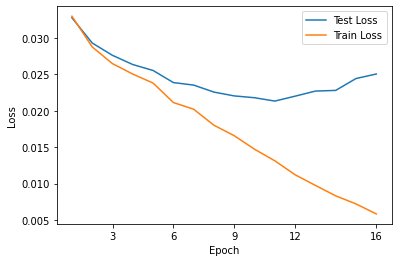

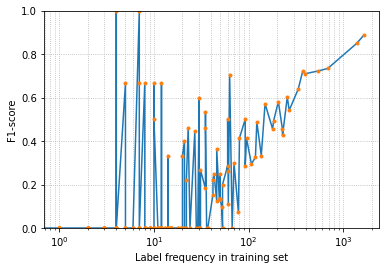

In [17]:
# set all values above threshold to 1, else 0
th = 0.5
y_pred = np.copy(y_pred_temp)
y_pred[y_pred > th] = 1
y_pred[y_pred <= th] = 0

# number of labels in test set
#labels_in_test = np.count_nonzero(np.sum(y_true, axis=0))
label_counts_test = np.sum(multilab_bin.transform(test_dataset['labels']), axis=0)
labels_in_test = np.count_nonzero(label_counts_test)

# number of labels in train set
label_counts_train = np.sum(multilab_bin.transform(train_dataset['labels']), axis=0)
labels_in_train = np.count_nonzero(label_counts_train)

# compute size of intersection between labels in train and test
label_counts_test[label_counts_test > 0] = 1
labels_bin_test = label_counts_test

label_counts_train[label_counts_train > 0] = 1
labels_bin_train = label_counts_train

labels_bin_sum = labels_bin_test + labels_bin_train
labels_intersect = np.count_nonzero(labels_bin_sum[labels_bin_sum == 2])

print(f'Number of labels in training set: {labels_in_train}/{y_true.shape[1]} ({labels_in_train/y_true.shape[1]*100:.2f} %)')
print(f'Number of labels in test set: {labels_in_test}/{y_true.shape[1]} ({labels_in_test/y_true.shape[1]*100:.2f} %)')
print(f'Number of labels present in both sets: {labels_intersect}/{y_true.shape[1]} ({labels_intersect/y_true.shape[1]*100:.2f} %)')
print()
print(f"Micro-average F1-score: {f1_score(y_true, y_pred, average='micro')}")
print(f"Weighted-average F1-score: {f1_score(y_true, y_pred, average='weighted', zero_division=1)}")
print(f"Macro-average F1-score: {f1_score(y_true, y_pred, average='macro', zero_division=1)}")
#print(f"Sample-average Jaccard score: {jaccard_score(y_true, y_pred, average='samples', zero_division=1)}")
print(f"Accuracy (exact match): {accuracy_score(y_true, y_pred)}")
print(f"Hamming Loss: {hamming_loss(y_true, y_pred)}")

x = [x for x in range(1,len(train_losses)+1)]
xticks = [x*len(train_losses)//5 for x in range(1,6)]
plt.plot(x, test_losses)
plt.plot(x, train_losses)
plt.legend(['Test Loss', 'Train Loss'])
plt.xticks(xticks,xticks)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# plot f1-score in relation to label frequency in training set
f1_per_label = f1_score(y_true, y_pred, average=None, zero_division=0)
label_counts_train = np.sum(multilab_bin.transform(train_dataset['labels']), axis=0)
label_counts_test = np.sum(multilab_bin.transform(test_dataset['labels']), axis=0)

# only include labels that are present in the test set
zipped = [(f1_per_label[i], label_counts_test[i], label_counts_train[i]) for i in range(len(label_counts_test)) if label_counts_test[i] > 0]
zipped = sorted(zipped, key=lambda tup: tup[2])

f1_per_label = [zipped[i][0] for i in range(len(zipped))]
label_counts_train = [zipped[i][2] for i in range(len(zipped))]

# make a regression over the data points
#s = UnivariateSpline(label_counts_train, f1_per_label, k=3, s=5)
#xs = np.linspace(1,label_counts_train[-1])
#ys = s(xs)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(label_counts_train, f1_per_label)
plt.plot(label_counts_train, f1_per_label, '.')
#plt.plot(xs,ys)
ax.set_xscale('log')
ax.set_ylim((0,1))
plt.xlabel('Label frequency in training set')
plt.ylabel('F1-score')
plt.grid(True, which='both', linestyle=':')
plt.show()

In [18]:
model.eval()

# get a list of tuples containing the samples sorted by loss
sorted_samples = []

for i in range(len(test_dataset)):
    text = str(test_dataset['text'][i])
    text = ' '.join(text.split())

    tokens = basic_tokenization(text)
    # if tokens is empty, add set tokens to ['x']
    if len(tokens) <= 1:
        tokens = ['x']

    text_len = len(tokens)
    ids = [0 for j in range(len(tokens))]
    for j in range(len(tokens)):
        if tokens[j] in word2idx:
            ids[j] = word2idx[tokens[j]]
        else:
            ids[j] = unk_tok

    text_len = torch.tensor([text_len], dtype=torch.long).cpu()
    ids = torch.tensor(ids, dtype=torch.long).to(device)
    
    y_pred_row = model(tokens, ids, text_len).detach().cpu()#.numpy()
    y_true = torch.tensor(multilab_bin.transform([test_dataset['labels'][i]]), dtype=torch.float)
    
    loss = criterion(y_pred_row, y_true)

    # turn y_pred_row to ones and zeros based on threshold 'th'
    y_pred_row[y_pred_row > th] = 1
    y_pred_row[y_pred_row <= th] = 0

    sorted_samples.append((y_pred_row, y_true, test_dataset['text'][i], loss))

    if False:
      print(text)
      print(f'Prediction: {multilab_bin.inverse_transform(y_pred_row)}')
      print(f'Labels: {test_dataset["labels"][i]}')
      print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')

sorted_samples = sorted(sorted_samples, key=lambda tup: tup[-1])

In [ ]:
# print the m percent best/worst predictions based on loss
m = 20
best_worst = 'worst'

nbr_elements = (len(test_dataset) * m) // 100

top_m = []
if best_worst == 'best':
  top_m = sorted_samples[:nbr_elements]
elif best_worst == 'worst':
  top_m = sorted_samples[len(sorted_samples)-nbr_elements:]
else:
  print('Please choose either "best" or "worst"')

for i in range(len(top_m)):
  tup = top_m[i]
  pred = multilab_bin.inverse_transform(tup[0])
  labels = multilab_bin.inverse_transform(tup[1])
  text = tup[2]
  loss = tup[3]

  print(f'Loss: {loss}')
  print(f'{text}')
  print(f'Prediction: {pred}')
  print(f'Labels: {labels}')
  print('- - - - - - - - - - - - - - - - - - - - - - - - -')

In [20]:
text = ''
#text = str(test_dataset['text'][i])
text = ' '.join(text.split())

tokens = basic_tokenization(text)
# if tokens is empty, add set tokens to ['x']
if len(tokens) <= 1:
    tokens = ['x']

text_len = len(tokens)
ids = [0 for i in range(len(tokens))]
for i in range(len(tokens)):
    if tokens[i] in word2idx:
        ids[i] = word2idx[tokens[i]]
    else:
        ids[i] = unk_tok

text_len = torch.tensor([text_len], dtype=torch.long).cpu()
ids = torch.tensor(ids, dtype=torch.long).to(device)

y_pred_row = model(tokens, ids, text_len).detach().cpu()#.numpy()

y_pred_row[y_pred_row > th] = 1
y_pred_row[y_pred_row <= th] = 0

print(multilab_bin.inverse_transform(y_pred_row))


[()]


In [21]:
input_1 = torch.ones(3, 10)
input_2 = torch.ones(5, 10) * 2
input_3 = torch.ones(7, 10) * 3

inputs = [input_3, input_2, input_1]
input_lengths = [7, 5, 3]

padded = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True)

print(padded)

packed = torch.nn.utils.rnn.pack_padded_sequence(padded, input_lengths, batch_first=True)

print(packed)

tensor([[[3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
         [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
         [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
         [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
         [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
         [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
         [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]],

        [[2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0

In [22]:
a = [1,2,3,4,5,6,7,8,9]
print(a[:3])
print(a[3:])

[1, 2, 3]
[4, 5, 6, 7, 8, 9]
